# Backlog

- Faire tourner MLFlow (docker-compose up) / ou poetry
- Le tester avec un petit modèle
- LDA + Topic analysis
- TFIDF + LogisticRegression, SGDClassifier
- BERT
- Target preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
from src.dataset import Dataset
import matplotlib.pyplot as plt
import nltk
import torch
import cuml
import cudf
import cupy as cp
import numpy as np

plt.style.use(['ggplot', 'https://raw.githubusercontent.com/AlanBlanchet/matplotlib_styles/master/vscode_blue.mplstyle'])

Dataset.init()
RUN_ANIMATION_CELLS = False

In [2]:
topics = Dataset("topics1.csv")
topics.df.head()

,title,text,target,original_text,original_title
0,enforce attribute decoration of classes/methods,following on from my recent question on large...,c#|xml|serialization|coding-style|.net-attributes,following on from my recent question on large...,enforce attribute decoration of classes/methods
1,loading system.servicemodel configuration sect...,"using c# .net 3.5 and wcf, i'm trying to write...",c#|.net|xml|wcf|configurationmanager,"using c# .net 3.5 and wcf, i'm trying to write...",loading system.servicemodel configuration sect...
2,generics in c# & accessing the static members ...,my question concerns c# and how to access stat...,c#|generics|static|methods|data-access,my question concerns c# and how to access stat...,generics in c# & accessing the static members ...
3,how to make a histogram in ipython notebook us...,i'm trying to make a histogram of a simple lis...,python|ggplot2|ipython|jupyter-notebook|python...,i'm trying to make a histogram of a simple lis...,how to make a histogram in ipython notebook us...
4,implementation of the bidirectional graph search,i am trying to implement a bi-directional gra...,java|search|graph|artificial-intelligence|bidi...,i am trying to implement a bi-directional gra...,implementation of the bidirectional graph search


Voici les types d'approches à tester :

- Bag of Words (BoW) pour nous
- Word Embeddings : Word2Vec

# Itération 1

Le but est de commencer à effectuer des prédictions le plus vite possible pour ensuite améliorer dans la prochaine itération. Ainsi, même si j'ai déjà remarquer quelque problèmes dans mon dataset, je vais faire des prédictions

## Bag of Words - TF IDF

Dans cet partie on va effectuer un bag of words avec tous les mots disponibles. 

On va ensuite appliquer l'algorithme du TF IDF afin d'obtenir nos vecteurs one hot encodés correspondant aux similitudes entre les titres. Ainsi on pourra visualiser la proximité des phrases.

In [3]:
f = nltk.FreqDist()
for t in topics.df["title"].to_pandas():
    f.update(t.split(" "))
print(len(f.items()))

46601


On a 19104 mots uniques à notre disposition pour effectuer nos prédictions. Or pour le moment on ne prédit rien. Commençons simplement par une visualisation des mots les plus importants de notre liste

In [4]:
f.most_common(10)

[('to', 17556),
 ('in', 14609),
 ('a', 11541),
 ('how', 10871),
 ('the', 7060),
 ('with', 6904),
 ('and', 6109),
 ('of', 5611),
 ('is', 5075),
 ('for', 4897)]

In [5]:
to_remove = {k:v for k,v in f.items() if v < 3}
len(to_remove)

36471

In [6]:
topics.df["short_title"] = topics.df["title"].to_pandas().parallel_apply(lambda x: ' '.join([t for t in x.split(" ") if t not in to_remove]))
topics.df["short_title"].head()

0                      enforce attribute decoration of
1                  loading configuration section using
2    generics in c# & accessing the static members ...
3    how to make a histogram in ipython notebook us...
4     implementation of the bidirectional graph search
Name: short_title, dtype: object

In [7]:
words = nltk.FreqDist()
for t in topics.df["short_title"].to_pandas():
    words.update(t.split(" "))
len(words)

10130

In [8]:
from cuml.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3)

labels = cudf.Series(topics.df["target"].str.split("|").to_pandas().parallel_apply(lambda x: x[0]))
labels_counts = labels.value_counts()
over_5_labels = labels_counts[labels_counts > 500].index
are_labels_in = labels.isin(over_5_labels)

y_labels = labels[are_labels_in].reset_index(drop=True).to_numpy()
y = topics.label2id(y_labels)
X = topics.df.loc[are_labels_in,"short_title"].reset_index(drop=True)
X = vectorizer.fit_transform(X)

In [9]:
from cuml.model_selection import train_test_split

# On utilise d'abord le premier target
X_train, X_test, y_train, y_test = train_test_split(cudf.DataFrame(X.toarray()), cudf.Series(np.array(y, dtype=np.float64)), test_size=0.2, stratify=y)
# Save memory
X_train = cp.sparse.csr_matrix(X_train.values)
X_test = cp.sparse.csr_matrix(X_test.values)

In [10]:
from cuml.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

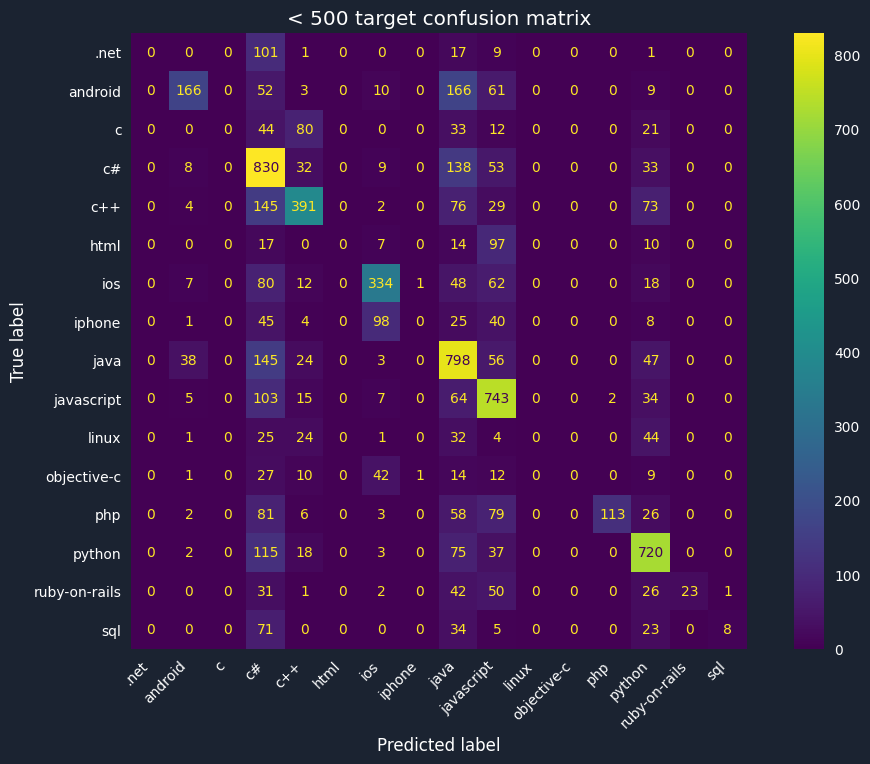

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

y_pred = naive_bayes.predict(X_test.toarray()).tolist()

disp = ConfusionMatrixDisplay.from_predictions(topics.id2label(y_test.to_numpy()), topics.id2label(y_pred))
plt.title("< 500 target confusion matrix")
plt.xticks(rotation=45, ha='right');
plt.grid(False)

In [12]:
print(classification_report(topics.id2label(y_test.to_numpy()), topics.id2label(y_pred), zero_division=0))

               precision    recall  f1-score   support

         .net       0.00      0.00      0.00       129
      android       0.71      0.36      0.47       467
            c       0.00      0.00      0.00       190
           c#       0.43      0.75      0.55      1103
          c++       0.63      0.54      0.58       720
         html       0.00      0.00      0.00       145
          ios       0.64      0.59      0.62       562
       iphone       0.00      0.00      0.00       221
         java       0.49      0.72      0.58      1111
   javascript       0.55      0.76      0.64       973
        linux       0.00      0.00      0.00       131
  objective-c       0.00      0.00      0.00       116
          php       0.98      0.31      0.47       368
       python       0.65      0.74      0.69       970
ruby-on-rails       1.00      0.13      0.23       176
          sql       0.89      0.06      0.11       141

     accuracy                           0.55      7523
    macr

Ici on remarque que beaucoup de prédictions sont faites pour le langage "C#" et que son score n'est pas terrible.

Cela peut s'expliquer par le fait que le titre des questions soit trop générique ou présente un concept de code qui peut s'appliquer dans différents langage. Ex: "Comment ajouter un élément à un tableau ?"

On ne pourrait donc pas déterminer le tag avec uniquement le titre.

Visualisons ces données

In [13]:
from src.tsne import tsne

if RUN_ANIMATION_CELLS:
    tsne("title_tsne", X, y, topics.id2label(y))


Faisons la même chose mais pour les descriptions

In [14]:
f = nltk.FreqDist()
for t in topics.df["text"].to_pandas():
    f.update(t.split(" "))

# Memory error if too much cols
to_remove = {k:v for k,v in f.items() if v < 40}

topics.df["short_text"] = topics.df["text"].to_pandas().parallel_apply(lambda x: ' '.join([t for t in x.split(" ") if t not in to_remove]))

vectorizer = TfidfVectorizer(min_df=3)

X = topics.df.loc[are_labels_in,"short_text"].reset_index(drop=True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(cudf.DataFrame(X.toarray()), cudf.Series(np.array(y, dtype=np.float64)), test_size=0.2, stratify=y)
X_train = cp.sparse.csr_matrix(X_train.values)
X_test = cp.sparse.csr_matrix(X_test.values)

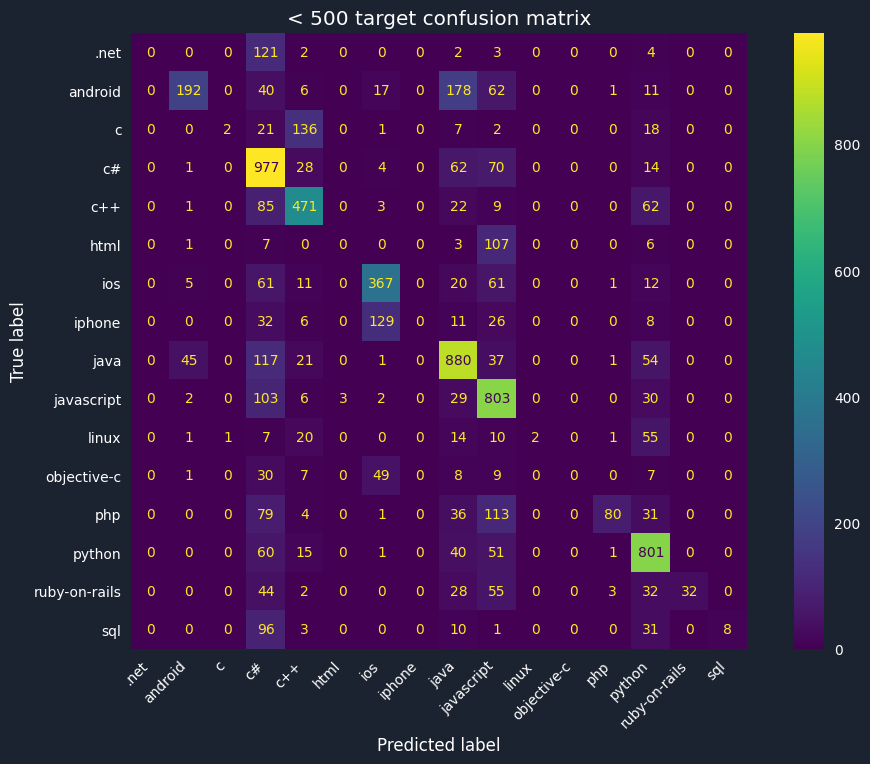

In [15]:
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test.toarray()).tolist()

disp = ConfusionMatrixDisplay.from_predictions(topics.id2label(y_test.to_numpy()), topics.id2label(y_pred))
plt.title("< 500 target confusion matrix")
plt.xticks(rotation=45, ha='right');
plt.grid(False)

In [16]:
from src.tsne import tsne

if RUN_ANIMATION_CELLS:
    tsne("text_tsne", X, y, topics.id2label(y))

In [17]:
len(y)

37619

In [18]:
from gensim.models import LdaModel, Word2Vec, LdaSeqModel
from gensim.corpora import Dictionary

topics.to("cpu")
docs = topics.df["short_text"].str.split(" ").values

dictionary = Dictionary(docs)
#dictionary.filter_extremes(no_below=2, no_above=1)

corpus = [dictionary.doc2bow(doc) for doc in docs]

len(dictionary), len(corpus)

(10995, 50000)

In [19]:
model = LdaModel(
    corpus=corpus,
    num_topics=len(y)
)

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [62]:
data = topics.df.loc[are_labels_in.to_numpy()].reset_index(drop=True)

In [70]:
from tqdm.contrib.concurrent import thread_map

def preprocess(data):
    title, label = data

    encoded = tokenizer(title, padding="max_length", truncation=True, max_length=50)

    encoded["label"] = label

    return encoded

encoding = thread_map(preprocess, zip(data["title"], y_labels))

0it [00:00, ?it/s]

In [72]:
tokenizer.decode(encoding[0]["input_ids"])

'[CLS] enforce attribute decoration of classes / methods [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [73]:
encoding[0]["label"]

'c#'

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=topics._id2label,
                                                           label2id=topics._label2id)